# Tensor Flowを用いたロジスティック回帰，MLP実装

# 0.  Tensorflowとは？

Googleが提供する機械学習用のフレームワーク．
機械学習用のフレームワークは他にもたくさん存在するが，Tensorflowは現在世界で最も使用されているフレームワークであると言われている．

pythonによって書くが、内部はC++やcudaによって書かれている．

### 'define and run'という形式をとり、まず計算グラフを定義し、それに対してデータを流すという使い方となっている．

※tensor flowインストールの際は，conda内でpipを使うとcondaのデータ破損原因になるので，$ conda install tensorflow　または，anaconda-navigator->Environmentsより，uninstall項目からtensorflowをinstallするのがよいと思われます．

### 必要なライブラリのインポート

In [1]:
import tensorflow as tf
from __future__ import print_function
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.cross_validation import train_test_split

/Users/tomoki/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
/Users/tomoki/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# 1.　計算グラフの構築と実行

計算グラフを構築するためにTensorflow側が用意している型を用いる必要がある.<br>

Tensorflowが用意している種類と使い方は以下のとおり．
1. tf.constant ... ハイパーパラメータなど，実行前から形(shape)の決まった定数に用いる．
2. tf.placeholder ... データの入力など，実行するまでデータのshapeはわからないが変わらないデータを入れるときに用いる(初期化不要)．例えば，データセットの大きさは実行するまでわからない．
3. tf.Variable ... ネットワークの重みなど，学習中に値が変わる最適化対象を入れる(初期化必要)． 

## 1.0　計算グラフの実行方法
計算グラフを構築するだけでは，実際に計算は行われない．<br>
計算を実行して値を評価するためには， TensorflowのSessionを作成する必要がある．<br>
例えば，$x$という値の出力が欲しい時は，その値をSessionのrunメソッドに渡してあげる．<br>
具体的には以下のように書けば良い．
```python
with tf.Session() as sess:
    result = sess.run(x)
```

## 1.1　まずはtf.constant(定数)を用いる

In [2]:
x = tf.constant(1)
y = tf.constant(2)

add_op = tf.add(x, y)
print(x,y)
print(add_op)

Tensor("Const:0", shape=(), dtype=int32) Tensor("Const_1:0", shape=(), dtype=int32)
Tensor("Add:0", shape=(), dtype=int32)


ここで表示された結果は定義された計算グラフについての情報で、実際に計算は行われていないことに注意．
- 以下のように計算グラフを実行させて値を確認する．

In [3]:
with tf.Session() as sess:
    print(sess.run(add_op))

3


In [4]:
with tf.Session() as sess:
    x_, y_, add_op_ = sess.run([x, y, add_op])

In [5]:
print('x is ',x_)
print('y is ', y_)
print('x + y = ',add_op_)

x is  1
y is  2
x + y =  3


### Tips tensorboard

In [6]:
import tensorboard as tb

In [7]:
tb.show_graph(tf.get_default_graph().as_graph_def())

足し算掛け算は以下のようにも書ける．

In [8]:
x = tf.constant(1)
y = tf.constant(2)

## 足し算掛け算は+,*で書いて良い
add_op = x+y

with tf.Session() as sess:
    x_, y_, add_op_ = sess.run([x, y, add_op])

In [9]:
print('x is ',x_)
print('y is ', y_)
print('x + y = ',add_op_)

x is  1
y is  2
x + y =  3


In [11]:
tb.show_graph(tf.get_default_graph().as_graph_def()) # 前のが残っている

## 1.2　tf.placeholderを用いる(データを流す用)

placeholderは初期化不要の変数だが、intかfloatか指定する必要がある．
- tf.float32
- tf.int32

評価対象の変数の計算のために必要なデータの入力はsess.run内のfeed_dict引数内で行うことができる．<br>
feed_dictで渡す変数は一つとは限らないので，辞書型で渡す．

In [12]:
data = tf.placeholder(tf.int32)
x = tf.constant(5)
op = data*x

with tf.Session() as sess:
    result1 = sess.run(op, feed_dict={data: 5})
    result2 = sess.run(op, feed_dict={data: 10})

In [13]:
print('5*5=',result1)
print('5*10=',result2)

5*5= 25
5*10= 50


## 1.3　tf.Variableを用いる(変数用)

- 実行前に全てのVariableは初期化する必要がある．
    - sess.run(tf.global_variables_initializer())で一度に初期化できる
- Variableへの代入はtf.assignを用いる

In [14]:
var1 = tf.Variable(0)
const1 = tf.constant(2)

add_op = var1+const1
# Variableへの代入はassignを用いる
var1 = tf.assign(var1, add_op)
print (var1)

Tensor("Assign:0", shape=(), dtype=int32_ref)


In [15]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
# var1が毎回更新されている
    print(sess.run([var1]))
    print(sess.run([var1]))
    print(sess.run([var1]))

[2]
[4]
[6]


# 2，MNIST分類

### 今回はKNNで扱った手書き文字分類を実装する．前回ロジスティック回帰で扱った問題は二値分類であったが，今回は多クラス分類問題となる．出力層の出力はsoftmax関数にし、誤差関数は交差エントロピー誤差を用いる．

### データの準備

In [53]:
from keras.utils import to_categorical

Using TensorFlow backend.


In [54]:
# データのロード（比較的時間がかかる）
mnist = fetch_mldata('MNIST original', data_home='./data/')

# data : 画像データ， target : 正解ラベル
X, T = mnist.data, mnist.target

# 画像データは0~255の数値となっているので，0~1の値に変換
X = X / 255.

#　訓練データとテストデータに分ける
X_train, X_test, T_train, T_test = train_test_split(X, T, test_size=0.2)

# データのサイズ
N_train = X_train.shape[0]
N_test = X_test.shape[0]

# ラベルデータをint型に統一し，学習に使いやすいようにone-hot-vectorに変換
#T_train = np.eye(10)[T_train.astype("int")]
#T_test = np.eye(10)[T_test.astype("int")]
T_train = to_categorical(T_train)
T_test = to_categorical(T_test)

In [55]:
print ('訓練データのサイズは', N_train)
print ('テストデータのサイズは', N_test)
print ('画像データのshapeは', X_train.shape)
print ('ラベルデータのshapeは', T_train.shape)
print ('ラベルデータの数値の例：')
print (T_train[:10])

訓練データのサイズは 56000
テストデータのサイズは 14000
画像データのshapeは (56000, 784)
ラベルデータのshapeは (56000, 10)
ラベルデータの数値の例：
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


## one-hot-vectorとは？
たとえば$a$が，0~4の整数のみを含むベクトルだとわかっている時に，各行の数字に該当する列の要素のみを1にし，その他を0にする．
$$
\begin{equation*}
a=
\begin{pmatrix}
3\\
1\\
4\\
2\\
0
\end{pmatrix}\to
a\_onehot = 
\begin{pmatrix}
0, 0, 0, 1, 0\\
0, 1, 0, 0, 0\\
0, 0, 0, 0, 1\\
0, 0, 1, 0, 0\\
1, 0, 0, 0, 0
\end{pmatrix}
\end{equation*}
$$
学習における正解ラベルデータは，one-hot-vectorで表されることが多い．

## MLPクラスの定義

In [56]:
class MLP:
    def __init__(self, n_in, n_out):
        # n_in : 入力次元数
        # n_out : 出力次元数
        self.W = tf.Variable(tf.zeros([n_in, n_out])) # 重み
        
        self.b = tf.Variable(tf.zeros(n_out)) # バイアス

    def __call__(self, x):
        ### TODO ###
        y = tf.nn.softmax(tf.matmul(x,self.W)+self.b) # Forward Propagation
        ### TODO ###
        return y

## グラフの構築

In [57]:
#グラフの初期化
tf.reset_default_graph()

In [58]:
#必要なパラメータの定義
# Learning rate (学習率)
lr = 0.7
# epoch数 （学習回数）
n_epoch = 25
# ミニバッチ学習における1バッチのデータ数
batchsize = 100

In [59]:
# 入力
# placeholderを用いると，データのサイズがわからないときにとりあえずNoneとおくことができる．
x = tf.placeholder(tf.float32, [None, 784]) # 28*28次元 
t = tf.placeholder(tf.float32, [None, 10]) # 10クラス

In [67]:
# モデルの定義
# 入力次元数：784，　出力次元数：10
model =MLP(784, 10)

In [68]:
# y : predictionの結果
y = model(x)

In [72]:
# 目的関数:softmax cross entropy
# 入力：labels->正解ラベル， logits：predictionの結果
# 出力：softmax cross entropyで計算された誤差
cost = -tf.reduce_mean(tf.reduce_sum(t*tf.log(tf.clip_by_value(y, 1e-10, 1.0)), reduction_indices=[1] )) # tf.log(0)によるnanを防ぐ

In [73]:
# SGD(Stochastic Gradient Descent : 確率的勾配降下法)で目的関数を最小化する
optimizer = tf.train.GradientDescentOptimizer(lr).minimize(cost)

In [74]:
# 精度評価
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(t, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## グラフの実行

In [75]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(n_epoch):
        print ('epoch %d | ' % epoch, end="")

        # Training
        sum_loss = 0
        # 訓練データをシャッフルする
        perm = np.random.permutation(N_train)

        for i in range(0, N_train, batchsize):
            # ミニバッチ分のデータを取ってくる
            X_batch = X_train[perm[i:i+batchsize]]
            t_batch = T_train[perm[i:i+batchsize]]

            _, loss = sess.run([optimizer, cost], feed_dict={x:X_batch, t:t_batch})
            sum_loss += np.mean(loss) * X_batch.shape[0]

        loss = sum_loss / N_train
        print('Train loss %.3f | ' %(loss), end="")

        # Test model
        print ("Accuracy: %.3f"%(accuracy.eval(feed_dict={x: X_test, t: T_test})))

epoch 0 | Train loss 0.396 | Accuracy: 0.908
epoch 1 | Train loss 0.304 | Accuracy: 0.908
epoch 2 | Train loss 0.291 | Accuracy: 0.911
epoch 3 | Train loss 0.283 | Accuracy: 0.913
epoch 4 | Train loss 0.277 | Accuracy: 0.917
epoch 5 | Train loss 0.274 | Accuracy: 0.917
epoch 6 | Train loss 0.272 | Accuracy: 0.919
epoch 7 | Train loss 0.269 | Accuracy: 0.916
epoch 8 | Train loss 0.266 | Accuracy: 0.920
epoch 9 | Train loss 0.265 | Accuracy: 0.919
epoch 10 | Train loss 0.264 | Accuracy: 0.905
epoch 11 | Train loss 0.260 | Accuracy: 0.919
epoch 12 | Train loss 0.259 | Accuracy: 0.918
epoch 13 | Train loss 0.259 | Accuracy: 0.918
epoch 14 | Train loss 0.257 | Accuracy: 0.916
epoch 15 | Train loss 0.257 | Accuracy: 0.920
epoch 16 | Train loss 0.256 | Accuracy: 0.919
epoch 17 | Train loss 0.255 | Accuracy: 0.921
epoch 18 | Train loss 0.254 | Accuracy: 0.916
epoch 19 | Train loss 0.253 | Accuracy: 0.914
epoch 20 | Train loss 0.253 | Accuracy: 0.920
epoch 21 | Train loss 0.252 | Accuracy: 0.91

## バッチ学習について
バッチ学習とは，大量のデータを扱う際に，データをいくつかの小さな集合にわけ，その集合ごとに勾配を計算し，パラメータを更新する手法である．今までは全てのデータを参照してから，一度重みの更新を行っていたため，大量の計算を行っても重み更新が少しづつしか行えない問題があった．バッチ学習はこの問題を解決する手法である．今回の問題では，56000個の訓練データを100個ずつのバッチに分けて，そのバッチごとに勾配計算する操作を一回の操作とし，その操作をepoch回数分(25回)分計算を回して重み更新を行う．つまり，$560×25=14000回$の重み更新を行っている．

# 3. MLP

## MLPクラスについて
以下のような要件のネットワークを構築する．
```
    入力 : x　
-> Fully connected layer 1 (input : x, outputの次元数 : 256, 活性化関数 : relu関数)
-> Fully connected layer 2 (input : layer1の出力， outputの次元数 : 256, 活性化関数 : relu関数)
-> Fully connected layer 3 (input : layer2の出力， outputの次元数 : 10)
-> 出力 : out
```

<details>
    <summary>ヒント</summary>
    <div><br>
    - TensorflowでFully connected layerはtf.layers.dense (inputs, units, activation=None)で呼ぶことができる．
    <br>
    - inputs : 入力データ
    <br>
    - units :  outputの次元数
    <br>
    - activation : 活性化関数の種類（デフォルトでは無し）
    <br>
    - relu関数はTensorflowでtf.nn.reluと表される．
    </div>
</details>

## MLPクラスの定義

In [76]:
def MLP(x):
    ### TODO
    layer_1 =  tf.layers.dense(x, 256, activation=tf.nn.relu)
    layer_2 =  tf.layers.dense(layer_1, 256, activation=tf.nn.relu)
    out = tf.layers.dense(layer_2, 10, activation=tf.nn.softmax)
    ### TODO
    return out

## グラフの構築

In [78]:
tf.reset_default_graph()

# パラメータ
# Learning rate (学習率)
lr = 0.1
# epoch数 （学習回数）
n_epoch = 25
# ミニバッチ学習における1バッチのデータ数
batchsize = 100

# 入力
# placeholderを用いると，データのサイズがわからないときにとりあえずNoneとおくことができる．
x = tf.placeholder(tf.float32, [None, 784]) # 28*28次元 
t = tf.placeholder(tf.float32, [None, 10]) # 10クラス

# MLPクラスのモデルを用いてpredictionを行う
y = MLP(x)

# 目的関数:softmax cross entropy
# 入力：labels->正解ラベル， logits：predictionの結果
# 出力：softmax cross entropyで計算された誤差
#xentropy = tf.nn.softmax_cross_entropy_with_logits(labels=t, logits=y)
#cost = tf.reduce_mean(xentropy)
cost = -tf.reduce_mean(tf.reduce_sum(t*tf.log(tf.clip_by_value(y, 1e-10, 1.0)),axis=1)) # tf.log(0)によるnanを防ぐ

# SGD(Stochastic Gradient Descent : 確率的勾配降下法)で目的関数を最小化する
optimizer = tf.train.GradientDescentOptimizer(lr).minimize(cost)

# test用
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(t, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## グラフの実行

In [79]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(n_epoch):
        print ('epoch %d | ' % epoch, end="")

        # Training
        sum_loss = 0
        # 訓練データをシャッフルする
        perm = np.random.permutation(N_train)

        for i in range(0, N_train, batchsize):
            # ミニバッチ分のデータを取ってくる
            X_batch = X_train[perm[i:i+batchsize]]
            t_batch = T_train[perm[i:i+batchsize]]
            
            _, loss = sess.run([optimizer, cost], feed_dict={x:X_batch, t:t_batch})
            sum_loss += np.mean(loss) * X_batch.shape[0]

        loss = sum_loss / N_train
        print('Train loss %.5f | ' %(loss), end="")

        # Test model
        print ("Test Accuracy: %.3f"%(accuracy.eval(feed_dict={x: X_test, t: T_test})))

epoch 0 | Train loss 0.39123 | Test Accuracy: 0.930
epoch 1 | Train loss 0.18031 | Test Accuracy: 0.952
epoch 2 | Train loss 0.13039 | Test Accuracy: 0.961
epoch 3 | Train loss 0.10164 | Test Accuracy: 0.965
epoch 4 | Train loss 0.08344 | Test Accuracy: 0.968
epoch 5 | Train loss 0.06964 | Test Accuracy: 0.971
epoch 6 | Train loss 0.05886 | Test Accuracy: 0.974
epoch 7 | Train loss 0.05103 | Test Accuracy: 0.972
epoch 8 | Train loss 0.04383 | Test Accuracy: 0.974
epoch 9 | Train loss 0.03802 | Test Accuracy: 0.975
epoch 10 | Train loss 0.03252 | Test Accuracy: 0.975
epoch 11 | Train loss 0.02830 | Test Accuracy: 0.977
epoch 12 | Train loss 0.02491 | Test Accuracy: 0.978
epoch 13 | Train loss 0.02087 | Test Accuracy: 0.977
epoch 14 | Train loss 0.01802 | Test Accuracy: 0.978
epoch 15 | Train loss 0.01596 | Test Accuracy: 0.977
epoch 16 | Train loss 0.01344 | Test Accuracy: 0.978
epoch 17 | Train loss 0.01166 | Test Accuracy: 0.977
epoch 18 | Train loss 0.01032 | Test Accuracy: 0.977
epo

# < Tensorflow 応用編 >

Tensorflowには学習コードをさらに抽象化する<strong>Estimator</strong>というものがある．<br>
Estimatorを用いるとEstimator.train()を呼ぶだけでepoch数だけfor文を書くなどの手間が省けるため，コードの可読性が上がり，<br>
実用でも広く使われている．

## Estimatorの使い方
Estimatorの使用方法について大まかなコードの流れの例を説明したものが以下のサンプルコードである．
```python
estimator = tf.estimator.Estimator(model_fn)
estimator.train(train_input_fn)
result = estimator.evaluate(test_input_fn)
```
model_fnにモデルの内容（ネットワーク構造，ロス関数，optimizerの設定）を書き，Estimatorに渡す．<br>
Estimatorは訓練用のデータの情報が入っているtrain_input_fnを引数としてtrainメソッドを呼ぶことで訓練を行う．<br>
さらに，テスト用のデータの情報が入っているtest_input_fnを引数としてevaluateメソッドを呼ぶことでテストを行い，学習データになかったデータに対する汎用性を評価する．

In [80]:
# Estimatorでの実装時に用いられる関数はone-hot-vectorではなくクラスラベルをそのまま入力することが多い?
t_train = np.argmax(T_train, axis=1)
t_test = np.argmax(T_test, axis=1)

### 注意！
loss関数の名前シリーズ


- tf.nn.tf.nn.softmax_cross_entropy
- tf.nn.tf.nn.softmax_cross_entropy_with_logits
- tf.nn.sparse_softmax_cross_entropy
- tf.nn.sparse_softmax_cross_entropy_with_logits


どれつかったらいいの...

### 重要

with_logitsがついているものはこの関数は内部でソフトマックスも計算するから、ニューラルネットワークの出力をそのまま入力してね、という意味です。

sparseが付いていると、自動でinputをone-hotにしてくれるそうです。はい、便利！

In [81]:
def my_model(features, labels, mode, params):
    # モデルを定義する
    net = features['x']
    for units in params['hidden_units']:
        # 入力がnetで出力がunits個，活性化関数がrelu関数である全結合層
        net = tf.layers.dense(net, units=units, activation=tf.nn.relu)

    # netを入力としてクラス分のunit数に出力することでlogitsを計算する
    logits = tf.layers.dense(net, params['n_classes'], activation=None)
    
    # ロスの定義
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

    # 推定結果を計算する
    predicted_classes = tf.argmax(logits, 1)
    
    # 正解率の計算方法を指定する
    accuracy = tf.metrics.accuracy(labels=labels, predictions=predicted_classes)
    metrics = {'accuracy': accuracy}
  
    # evaluationモードのとき
    if mode == tf.estimator.ModeKeys.EVAL:
        return tf.estimator.EstimatorSpec(mode, loss=loss, eval_metric_ops=metrics)

    # lossを最小化するオプティマイザを定義する
    optimizer = tf.train.AdagradOptimizer(learning_rate=0.1)
    train_op = optimizer.minimize(loss, global_step=tf.train.get_global_step())
     
    # trainモードのとき
    return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train_op)

In [82]:
def main():
    batch_size = 100

    # 訓練データ用
    train_input_fn = tf.estimator.inputs.numpy_input_fn(
        x={"x": X_train},
        y=t_train,
        batch_size=batch_size,
        num_epochs=5,
        shuffle=True)
    
    # テストデータ用
    eval_input_fn = tf.estimator.inputs.numpy_input_fn(
        x={"x": X_test},
        y=t_test,
        num_epochs=1,
        shuffle=False)

    # model functionを用いてestimatorを定義する
    estimator = tf.estimator.Estimator(
        model_fn=my_model,
        params={
            'hidden_units': [256, 256], #  256ノード持つ2つの隠れ層
            'n_classes': 10, # モデルは結果を3つのクラスから選ぶ
        })
     
    # モデルを訓練
    estimator.train(input_fn=train_input_fn)
    
    # モデルの評価
    eval_result = estimator.evaluate(input_fn=eval_input_fn)
    
    print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_result))

In [83]:
main()

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_global_id_in_cluster': 0, '_session_config': None, '_save_checkpoints_secs': 600, '_service': None, '_task_type': 'worker', '_is_chief': True, '_tf_random_seed': None, '_evaluation_master': '', '_model_dir': '/var/folders/lw/8lq2svx57bl7js94tsvvtcdh0000gn/T/tmp4nku5wqa', '_num_worker_replicas': 1, '_save_summary_steps': 100, '_log_step_count_steps': 100, '_keep_checkpoint_every_n_hours': 10000, '_save_checkpoints_steps': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1138a3cc0>, '_master': '', '_task_id': 0, '_keep_checkpoint_max': 5, '_num_ps_replicas': 0}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/lw/8lq2svx57bl7js94tsvvtcdh000

## Tensor Flowを用いた回帰，二値分類の問題

### 前回MLP問題として扱った回帰，二値分類の問題をTensor Flowを用いて実装する

## $f(x)=x+0.3\sin(2\pi x)$ に沿って生成したノイズを含むデータ点から，近似曲線を推定する

### 必要なライブラリのインポート 

In [84]:
import pylab as plt
import numpy as np

### データの作成

In [85]:
def create_toy_dataset(func, n=100):
    #サイズ(n,1)の配列に0~1の乱数を格納
    x = np.random.uniform(size=(n, 1))
    #関数の返り値にノイズを発生
    t = func(x) + np.random.uniform(-0.1, 0.1, size=(n, 1))
    return x, t

#f(x)=x+0.3sin(2πx)を定義
def func(x):
        return x + 0.3 * np.sin(2 * np.pi * x)

In [86]:
#学習データ
x, t = create_toy_dataset(func)
x_size=x.shape[0]

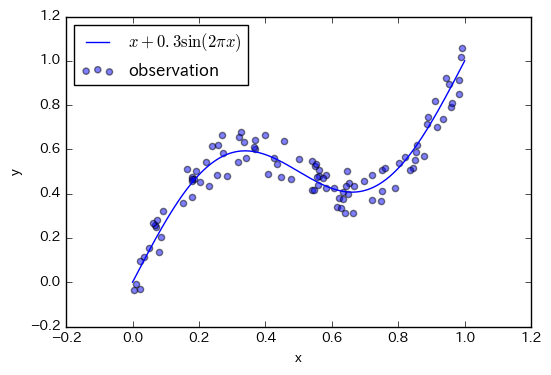

In [87]:
#観測データと正解の関数

plt.scatter(x, t, alpha=0.5, label="observation")
x_test = np.linspace(0, 1, 1000)[:, np.newaxis]
plt.plot(x_test, func(x_test), color="blue", label="$x+0.3\sin(2\pi x)$")
plt.legend(loc="upper left")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

### MLPクラスの定義

In [88]:
def MLP(x):
    ### TODO
    layer_1 =  tf.layers.dense(x, 3, activation=tf.nn.tanh)
    out = tf.layers.dense(layer_1, 1)
    ### TODO
    return out

### グラフの構築

In [89]:
tf.reset_default_graph()

# パラメータ
# Learning rate (学習率)
lr = 0.1
# epoch数 （学習回数）
n_epoch = 5000
# ミニバッチ学習における1バッチのデータ数
batchsize = 10

# 入力
# placeholderを用いると，データのサイズがわからないときにとりあえずNoneとおくことができる．
x_ = tf.placeholder(tf.float32, [None, 1]) # 1次元 
t_ = tf.placeholder(tf.float32, [None, 1]) # 1次元

# MLPクラスのモデルを用いてpredictionを行う
y_ = MLP(x_)

# 目的関数:softmax cross entropy
# 入力：labels->正解ラベル， logits：predictionの結果
# 出力：softmax cross entropyで計算された誤差
cost = tf.reduce_mean(tf.square(y_ - t_))

# SGD(Stochastic Gradient Descent : 確率的勾配降下法)で目的関数を最小化する
optimizer = tf.train.GradientDescentOptimizer(lr).minimize(cost)

# test用
correct_prediction = tf.equal(tf.argmax(y_, 1), tf.argmax(t_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

epoch 0 | Train loss 0.18719  
epoch 1 | Train loss 0.05401  
epoch 2 | Train loss 0.03657  
epoch 3 | Train loss 0.03088  
epoch 4 | Train loss 0.02840  
epoch 5 | Train loss 0.02616  
epoch 6 | Train loss 0.02623  
epoch 7 | Train loss 0.02548  
epoch 8 | Train loss 0.02509  
epoch 9 | Train loss 0.02469  
epoch 10 | Train loss 0.02646  
epoch 11 | Train loss 0.02592  
epoch 12 | Train loss 0.02568  
epoch 13 | Train loss 0.02746  
epoch 14 | Train loss 0.02543  
epoch 15 | Train loss 0.02516  
epoch 16 | Train loss 0.02572  
epoch 17 | Train loss 0.02546  
epoch 18 | Train loss 0.02765  
epoch 19 | Train loss 0.02698  
epoch 20 | Train loss 0.02480  
epoch 21 | Train loss 0.02386  
epoch 22 | Train loss 0.02532  
epoch 23 | Train loss 0.02566  
epoch 24 | Train loss 0.02447  
epoch 25 | Train loss 0.02535  
epoch 26 | Train loss 0.02389  
epoch 27 | Train loss 0.02654  
epoch 28 | Train loss 0.02530  
epoch 29 | Train loss 0.02527  
epoch 30 | Train loss 0.02540  
epoch 31 | Train l

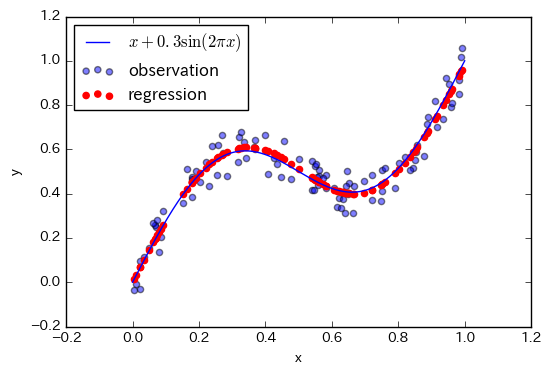

In [90]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    
    for epoch in range(n_epoch):
        print ('epoch %d | ' % epoch, end="")

        # Training
        sum_loss = 0
        # 訓練データをシャッフルする
        perm = np.random.permutation(x_size)
    
        for i in range(0, x_size, batchsize):
            
            # ミニバッチ分のデータを取ってくる
            X_batch = x[perm[i:i+batchsize]]
            t_batch = t[perm[i:i+batchsize]]

            _, loss = sess.run([optimizer, cost], feed_dict={x_:X_batch, t_:t_batch})
            sum_loss += np.mean(loss) * X_batch.shape[0]

        loss = sum_loss /x_size
        print('Train loss %.5f  ' %(loss))
        
        # Test model
        #print ("Test Accuracy: %.3f"%(sess.run(accuracy,feed_dict={x_: x, t_: t})))
    pred,x_data=sess.run([y_,x_], feed_dict={x_:x, t_:t})
    plt.scatter(x, t, alpha=0.5, label="observation")    
    x_test = np.linspace(0, 1, 1000)[:, np.newaxis]
    plt.plot(x_test, func(x_test), color="blue", label="$x+0.3\sin(2\pi x)$")
    plt.scatter(x_data, pred, color="red", label="regression")
    plt.legend(loc="upper left")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

## 二値分類

In [91]:
def create_toy_dataset2():
    x = np.random.uniform(-1., 1., size=(1000, 2))
    labels = (np.prod(x, axis=1) > 0).astype(np.float)
    return x, labels.reshape(-1, 1)





In [92]:
#データ生成
x, labels = create_toy_dataset2()
print(x.shape)
x_size=x.shape[0]

(1000, 2)


(1000, 2)
(1000, 1)


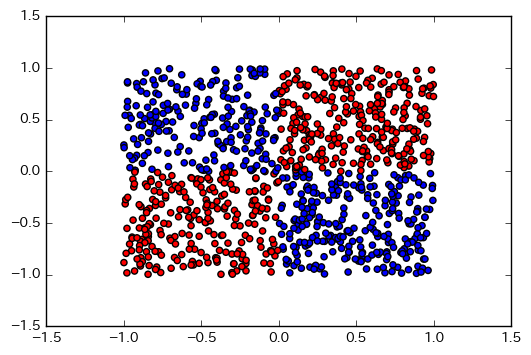

In [93]:
#可視化
print(x.shape)
print(labels.shape)
colors = ["blue", "red"]
plt.scatter(x[:, 0], x[:, 1], c=[colors[int(label)] for label in labels])
plt.show()


In [98]:
def MLP(x):
    ### TODO
    layer_1 =  tf.layers.dense(x, 4, activation=tf.nn.tanh)
    out = tf.layers.dense(layer_1, 1,activation=tf.nn.sigmoid)
    ### TODO
    return out

In [99]:
tf.reset_default_graph()

# パラメータ
# Learning rate (学習率)
lr = 0.001
# epoch数 （学習回数）
n_epoch = 1000

# ミニバッチ学習における1バッチのデータ数
batchsize = 1000

# 入力
# placeholderを用いると，データのサイズがわからないときにとりあえずNoneとおくことができる．
x_ = tf.placeholder(tf.float32, [None, 2]) # 1次元 
t_ = tf.placeholder(tf.float32, [None, 1]) # 1次元

# MLPクラスのモデルを用いてpredictionを行う
y_ = MLP(x_)

# 目的関数:負の対数尤度
cost = tf.reduce_sum(-t_ * tf.log(y_) - (1 - t_) * tf.log(1 - y_))

# SGD(Stochastic Gradient Descent : 確率的勾配降下法)で目的関数を最小化する
optimizer = tf.train.GradientDescentOptimizer(lr).minimize(cost)

# test用
correct_prediction = tf.equal(tf.argmax(y_, 1), tf.argmax(t_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

epoch 0 | Train loss 745.52478  
epoch 1 | Train loss 719.37830  
epoch 2 | Train loss 704.27576  
epoch 3 | Train loss 695.07245  
epoch 4 | Train loss 689.01886  
epoch 5 | Train loss 684.60706  
epoch 6 | Train loss 681.00598  
epoch 7 | Train loss 677.75220  
epoch 8 | Train loss 674.58008  
epoch 9 | Train loss 671.33301  
epoch 10 | Train loss 667.91370  
epoch 11 | Train loss 664.25891  
epoch 12 | Train loss 660.32532  
epoch 13 | Train loss 656.08240  
epoch 14 | Train loss 651.50891  
epoch 15 | Train loss 646.59033  
epoch 16 | Train loss 641.31775  
epoch 17 | Train loss 635.68744  
epoch 18 | Train loss 629.69965  
epoch 19 | Train loss 623.35889  
epoch 20 | Train loss 616.67273  
epoch 21 | Train loss 609.65247  
epoch 22 | Train loss 602.31189  
epoch 23 | Train loss 594.66766  
epoch 24 | Train loss 586.73901  
epoch 25 | Train loss 578.54712  
epoch 26 | Train loss 570.11536  
epoch 27 | Train loss 561.46826  
epoch 28 | Train loss 552.63202  
epoch 29 | Train loss 54

/Users/tomoki/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/Users/tomoki/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


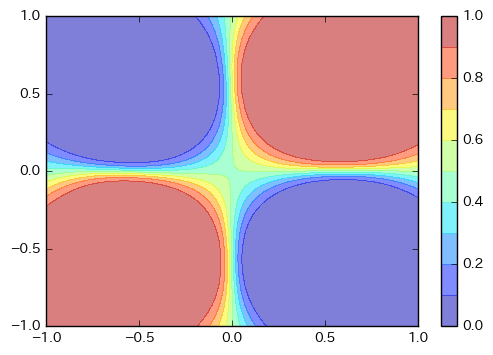

In [100]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    
    for epoch in range(n_epoch):
        print ('epoch %d | ' % epoch, end="")

        # Training
        sum_loss = 0
        # 訓練データをシャッフルする
        perm = np.random.permutation(x_size)
    
        for i in range(0, x_size, batchsize):
            
            # ミニバッチ分のデータを取ってくる
            X_batch = x[perm[i:i+batchsize]]
            t_batch = labels[perm[i:i+batchsize]]

            _, loss = sess.run([optimizer, cost], feed_dict={x_:X_batch, t_:t_batch})
            
            sum_loss += np.mean(loss) * X_batch.shape[0]

        loss = sum_loss /x_size
        print('Train loss %.5f  ' %(loss))

        # Test model
        #print ("Test Accuracy: %.3f"%(accuracy.eval(feed_dict={x_: x, t_: labels})))
    
    X_test, Y_test = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
    x_test = np.array([X_test, Y_test]).transpose(1, 2, 0).reshape(-1, 2)    
    probs = sess.run(y_, feed_dict={x_:x_test, t_:labels})
    Probs = probs.reshape(100, 100)
    levels = np.linspace(0, 1, 11)
    plt.contourf(X_test, Y_test, Probs, levels, alpha=0.5)
    plt.colorbar()
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.show()